In [1]:
import csv
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import Preprocessing as pp
from scipy.io import loadmat
from sklearn import metrics
import warnings
warnings.filterwarnings(action='once')

In [2]:
temp_data_folder = '../Data/Temp_Data/'

## Import Data and small visualisation

In [3]:
df_validation = pp.openCSVFile('experiment_1_short.csv', temp_data_folder)

In [4]:
df_validation

,spinning_soll,time,el_power,th_power,input_voltage,spinning_ist
0,3995.032402,816.66434,1262.974403,5629.445104,10,3073
1,3997.257544,817.66344,1248.077560,5053.778423,10,3073
2,3994.803267,818.66254,1245.101476,5552.107288,10,3073
3,3998.759567,819.66164,1275.365542,5040.901647,10,3073
4,3996.288215,820.66074,1263.214415,5195.793514,10,3073
...,...,...,...,...,...,...
9920,3073.746142,10728.25174,962.304148,9428.635990,3,0
9921,3070.180076,10729.25084,967.195581,9660.552297,3,0
9922,3072.540249,10730.24994,944.425298,9858.640540,3,0
9923,3067.327744,10731.24904,963.005732,9652.190866,3,0


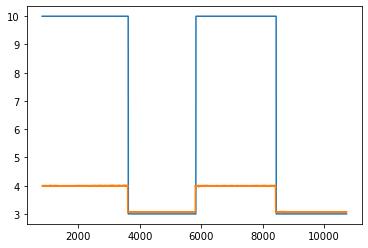

In [5]:
plt.plot(df_validation['time'], df_validation['input_voltage'])
plt.plot(df_validation['time'], df_validation['spinning_soll']/1000)
plt.show()

In [6]:
df_input = pp.openCSVFile('experiment_4b_short.csv', temp_data_folder)

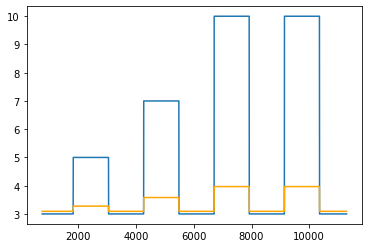

In [7]:
plt.plot(df_input['time'], df_input['input_voltage'])
plt.plot(df_input['time'], df_input['spinning_soll']/1000, 'orange')
plt.show()

## Predict spinning amount based on input

In [8]:
from sklearn import linear_model

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [9]:
reg_spin = linear_model.Ridge()
reg_spin.fit(df_input[['input_voltage', 'time']], df_input['spinning_soll'])

Ridge()

In [10]:
df_validation['spin_predict'] = reg_spin.predict(df_validation[['input_voltage', 'time']])

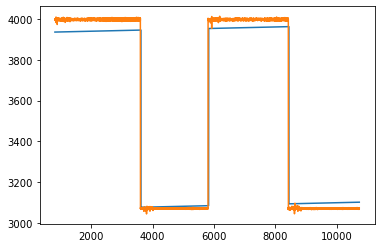

In [11]:
plt.plot(df_validation['time'], df_validation['spin_predict'])
plt.plot(df_validation['time'], df_validation['spinning_soll'])

In [12]:
def measureDifference(data, value_header, approx_header, print_text = True):
    R_SQUARED = True
    RSME = True
    PRINT = print_text
    
    rms, r2 = 0,0
    
    data = data[data[approx_header].notnull()]
    values = data[value_header]
    approx = data[approx_header]
    
    if RSME:
        rms = metrics.mean_squared_error(values, approx, squared=False)
    if R_SQUARED:
        r2 = metrics.r2_score(values, approx)
    if PRINT:
        print('The RMSE is %5.3f' %rms)
        print('The R2-score is %5.3f' %r2)
    return rms, r2

In [13]:
measureDifference(df_validation, 'spinning_soll', 'spin_predict')

The RMSE is 76.895
The R2-score is 0.972


(76.89527056460041, 0.9721825853420422)

## Predict spinning with amounts

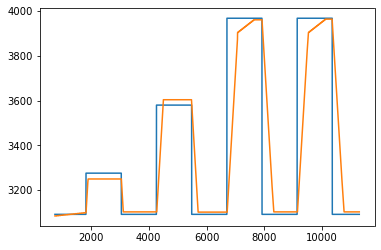

In [14]:
plt.plot(df_input['time'], df_input['spinning_soll'])
plt.plot(df_input['time'], df_input['spinning_approx'])

In [15]:
reg_spin = linear_model.Ridge()
reg_spin.fit(df_input[['spinning_approx']], df_input['el_power'])

Ridge()

In [16]:
df_validation['el_predict_ist'] = reg_spin.predict(df_validation[['spinning_ist']])

## Predict voltage amount based on input

In [17]:
reg_volt = linear_model.Ridge()
reg_volt.fit(df_input[['input_voltage']], df_input['el_power'])

Ridge()

In [18]:
df_validation['el_predict'] = reg_volt.predict(df_validation[['input_voltage']])

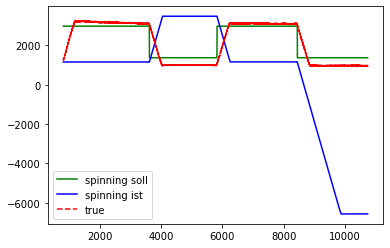

In [19]:
plt.plot(df_validation['time'], df_validation['el_predict'], 'green', label = 'spinning soll')
plt.plot(df_validation['time'], df_validation['el_predict_ist'], 'blue', label = 'spinning ist')
plt.plot(df_validation['time'], df_validation['el_power'], 'r--', label = 'true')
plt.legend()

In [20]:
measureDifference(df_validation, 'el_power', 'el_predict')

The RMSE is 458.693
The R2-score is 0.794


(458.69329840637926, 0.7936268633687399)

In [21]:
measureDifference(df_validation, 'el_power', 'el_predict_ist')

The RMSE is 3294.313
The R2-score is -9.645


(3294.312551250931, -9.644811535003047)

## Predict electrical output amount based on constraints

In [22]:
reg_thermal = linear_model.Ridge()
reg_thermal.fit(np.array(df_input['spinning_approx']).reshape(-1,1), df_input['th_power'])

Ridge()

In [23]:
df_validation['th_predict'] = reg_thermal.predict(df_validation[['spinning_ist']])

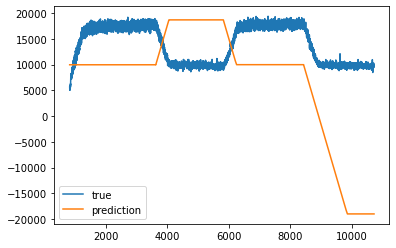

In [24]:
plt.plot(df_validation['time'], df_validation['th_power'], label = 'true')
plt.plot(df_validation['time'], df_validation['th_predict'], label = 'prediction')
plt.legend()

In [25]:
measureDifference(df_validation, 'th_power', 'th_predict')

The RMSE is 12551.124
The R2-score is -10.576


(12551.12366766794, -10.575868441412748)

## Comparison of multiple ML approaches 

In [26]:
approaches = ['LinReg', 'NNs', 'GPR']

In [27]:
from sklearn import linear_model, gaussian_process, neural_network

In [28]:
def mlswitch(argument, j):
    rs = np.random.RandomState(j)
    switcher = {
        'LinReg' : linear_model.LinearRegression(),
        'Ridge' : linear_model.Ridge(random_state=rs),
        'SGD' : linear_model.SGDRegressor(random_state=rs),
        'GPR' : gaussian_process.GaussianProcessRegressor(random_state=rs),
        'NNs' : neural_network.MLPRegressor(hidden_layer_sizes= (100,100,50,50,30,30,), max_iter = 500, random_state=rs)
    }
    return switcher.get(argument, 'Invalid')

In [29]:
from statistics import mean
import timeit

def compareMLApproaches(approaches, inputs):
    df_compared = pd.DataFrame()
    df_compared['approach'] = approaches
    for a in inputs:
        df_compared[a[1] + '_rms'] = 0
        df_compared[a[1] + '_r2'] = 0
        df_compared[a[1] + '_time'] = 0
        time_all_ap, rms_all_ap, r2_all_ap = [],[], []
        fig, axs = plt.subplots(2,2, figsize=(20,20))
        axs = axs.ravel()
        for i in range(len(approaches)):
            all_rms, all_r2, all_times, predictions = [], [], [], []
            for j in range(1):
                start = timeit.default_timer()
                model = mlswitch(approaches[i], j)
                model.fit(np.array(df_input['spinning_approx']).reshape(-1,1), a[0])
                stop= timeit.default_timer()
                time = stop - start
                pred = model.predict(df_validation[['spinning_ist']])
                predictions.append(pred)
                rms = metrics.mean_squared_error(df_validation[a[1]], pred, squared=False)
                r2 = metrics.r2_score(df_validation[a[1]], pred)
                all_times.append(time)
                all_rms.append(rms)
                all_r2.append(r2)
            rms_all_ap.append(all_rms)
            r2_all_ap.append(all_r2)
            time_all_ap.append(all_times)
            df_compared.loc[i, a[1] + '_rms'] = mean(all_rms)
            df_compared.loc[i, a[1] + '_r2'] = mean(all_r2)
            df_compared.loc[i, a[1] + '_time'] = mean(all_times)
            df_validation['predictions_' + a[1] + "_" + approaches[i]] = np.mean(predictions, axis = 0)
        axs[0].boxplot(rms_all_ap)
        axs[0].set_title('Comparison RMS between approaches (50 runs)')
        axs[0].set_xlabel(approaches)
        axs[0].set_ylabel('RMS')
        axs[1].boxplot(r2_all_ap)
        axs[1].set_title('Comparison R^2 between approaches (50 runs)')
        axs[1].set_xlabel(approaches)
        axs[1].set_ylabel('R^2')
        axs[2].boxplot(time_all_ap)
        axs[2].set_title('Comparison time between approaches (50 runs)')
        axs[2].set_xlabel(approaches)
        axs[2].set_ylabel('Time')
    return df_compared

,approach,th_power_rms,th_power_r2,th_power_time,el_power_rms,el_power_r2,el_power_time
0,LinReg,12551.123678,-10.575868,0.212209,3294.312554,-9.644812,0.087327
1,NNs,5939.691112,-1.592484,2.468536,1158.181091,-0.315713,3.418247
2,GPR,13922.161014,-13.243006,17.152199,2333.020120,-4.338821,17.020737


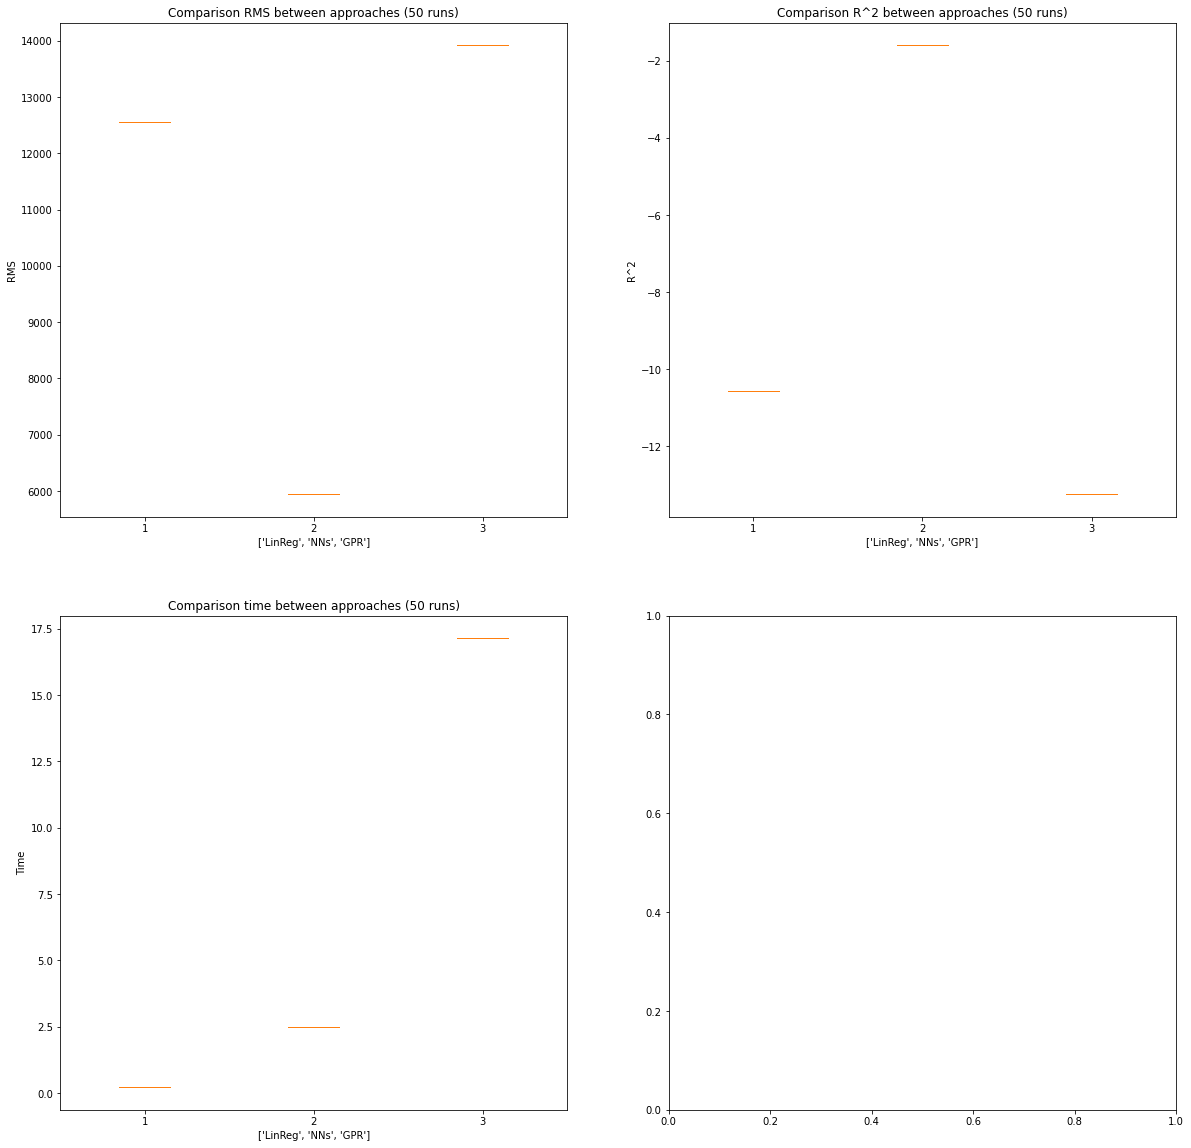

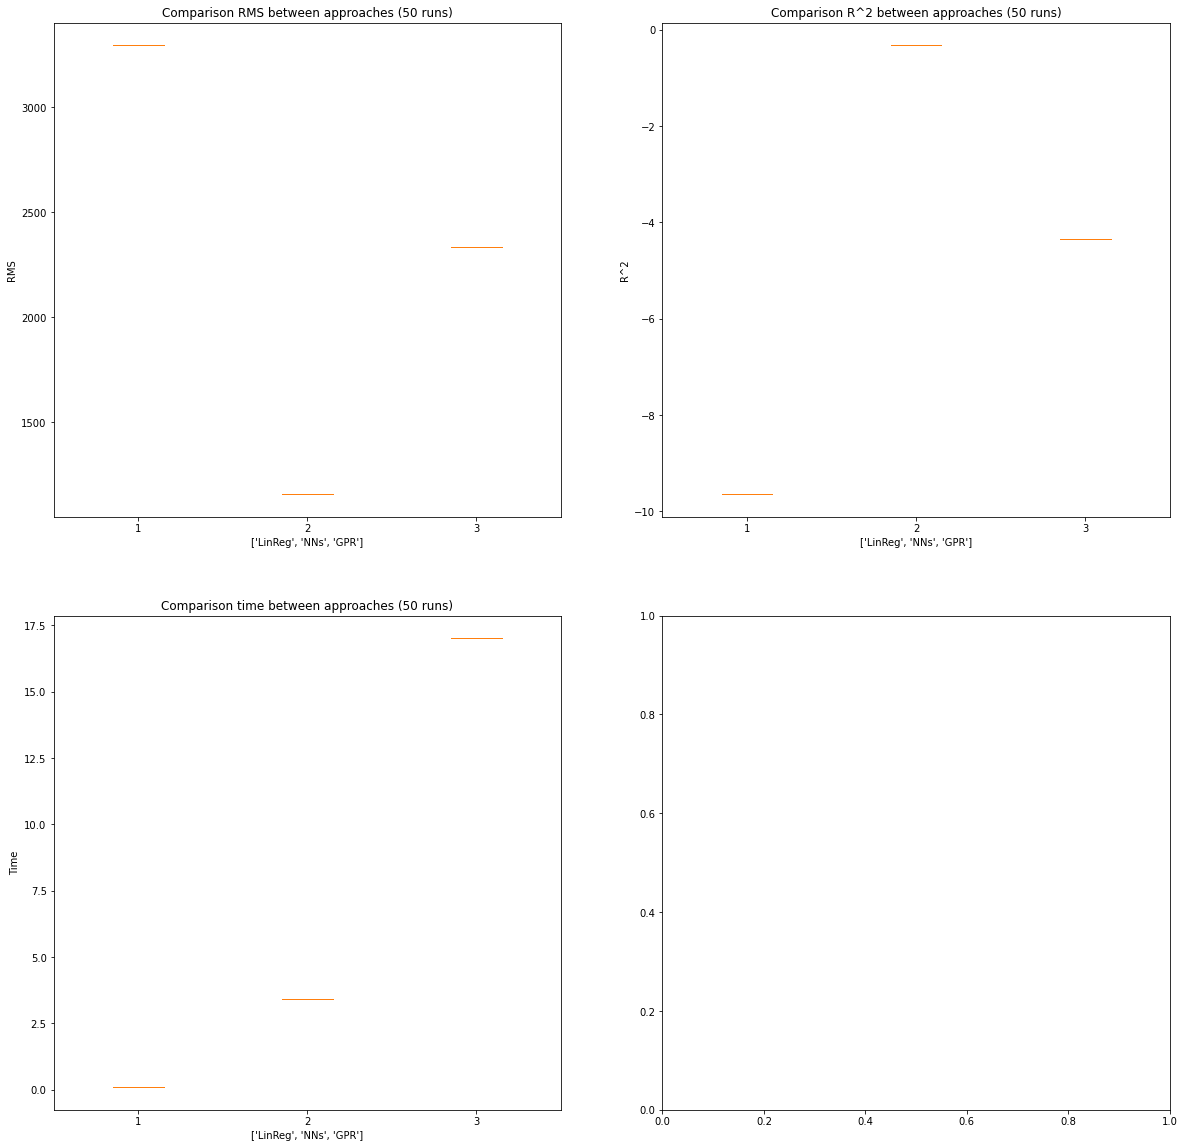

In [30]:
compareMLApproaches(approaches, [[df_input['th_power'], 'th_power'], [df_input['el_power'], 'el_power']])

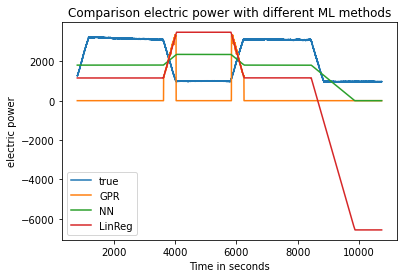

In [31]:
plt.plot(df_validation['time'],df_validation['el_power'], label = 'true')
plt.plot(df_validation['time'],df_validation['predictions_el_power_GPR'], label = 'GPR')
plt.plot(df_validation['time'],df_validation['predictions_el_power_NNs'], label = 'NN')
plt.plot(df_validation['time'],df_validation['predictions_el_power_LinReg'], label = 'LinReg')
plt.title('Comparison electric power with different ML methods')
plt.xlabel('Time in seconds')
plt.ylabel('electric power')
plt.legend()

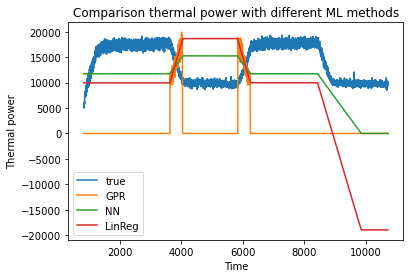

In [32]:
plt.plot(df_validation['time'],df_validation['th_power'], label = 'true')
plt.plot(df_validation['time'],df_validation['predictions_th_power_GPR'], label = 'GPR')
plt.plot(df_validation['time'],df_validation['predictions_th_power_NNs'], label = 'NN')
plt.plot(df_validation['time'],df_validation['predictions_th_power_LinReg'], label = 'LinReg')
plt.title('Comparison thermal power with different ML methods')
plt.xlabel('Time')
plt.ylabel('Thermal power')
plt.legend()

## Compare on experiment 9 

In [33]:
df_9 = pp.openCSVFile('experiment_9_short.csv', temp_data_folder)

In [38]:
def compareMLApproaches9(approaches, inputs):
    df_compared = pd.DataFrame()
    df_compared['approach'] = approaches
    for a in inputs:
        df_compared[a[1] + '_rms'] = 0
        df_compared[a[1] + '_r2'] = 0
        df_compared[a[1] + '_time'] = 0
        time_all_ap, rms_all_ap, r2_all_ap = [],[], []
#         fig, axs = plt.subplots(2,2, figsize=(20,20))
#         axs = axs.ravel()
        for i in range(len(approaches)):
            all_rms, all_r2, all_times, predictions = [], [], [],[]
            for j in range(1):
                start = timeit.default_timer()
                model = mlswitch(approaches[i], j)
                model.fit(np.array(df_input['spinning_approx']).reshape(-1,1), a[0])
                stop= timeit.default_timer()
                time = stop - start
                pred = model.predict(df_9[['spinning_approx']])
                predictions.append(pred)
                rms = metrics.mean_squared_error(df_9[a[1]], pred, squared=False)
                r2 = metrics.r2_score(df_9[a[1]], pred)
                all_times.append(time)
                all_rms.append(rms)
                all_r2.append(r2)
            rms_all_ap.append(all_rms)
            r2_all_ap.append(all_r2)
            time_all_ap.append(all_times)
            df_compared.loc[i, a[1] + '_rms'] = mean(all_rms)
            df_compared.loc[i, a[1] + '_r2'] = mean(all_r2)
            df_compared.loc[i, a[1] + '_time'] = mean(all_times)
            df_9['predictions_' + a[1] + "_" + approaches[i]] = np.mean(predictions, axis = 0)
#         axs[0].boxplot(rms_all_ap)
#         axs[0].set_title('Comparison RMS between approaches (50 runs)')
#         axs[0].set_xlabel(approaches)
#         axs[0].set_ylabel('RMS')
#         axs[1].boxplot(r2_all_ap)
#         axs[1].set_title('Comparison R^2 between approaches (50 runs)')
#         axs[1].set_xlabel(approaches)
#         axs[1].set_ylabel('R^2')
#         axs[2].boxplot(time_all_ap)
#         axs[2].set_title('Comparison time between approaches (50 runs)')
#         axs[2].set_xlabel(approaches)
#         axs[2].set_ylabel('Time')
    return df_compared

In [39]:
compareMLApproaches9(approaches, [[df_input['th_power'], 'th_power'], [df_input['el_power'], 'el_power']])

,approach,th_power_rms,th_power_r2,th_power_time,el_power_rms,el_power_r2,el_power_time
0,LinReg,1172.105412,0.519987,0.001159,127.956819,0.899760,0.085306
1,NNs,1301.269776,0.408365,2.369256,344.173017,0.274781,3.411449
2,GPR,1313.346986,0.397332,17.196787,114.515167,0.919714,17.851944


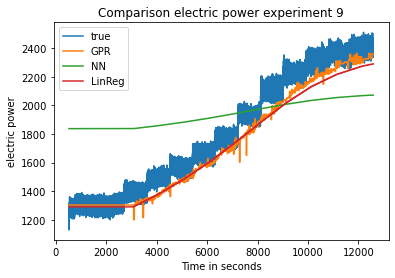

In [36]:
plt.plot(df_9['time'],df_9['el_power'], label = 'true')
plt.plot(df_9['time'],df_9['predictions_el_power_GPR'], label = 'GPR')
plt.plot(df_9['time'],df_9['predictions_el_power_NNs'], label = 'NN')
plt.plot(df_9['time'],df_9['predictions_el_power_LinReg'], label = 'LinReg')
plt.title('Comparison electric power experiment 9')
plt.xlabel('Time in seconds')
plt.ylabel('electric power')
plt.legend()

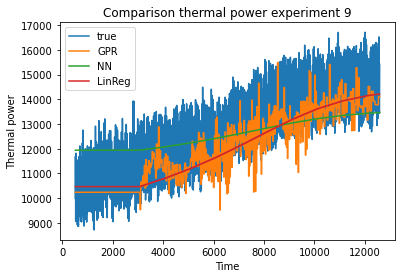

In [37]:
plt.plot(df_9['time'],df_9['th_power'], label = 'true')
plt.plot(df_9['time'],df_9['predictions_th_power_GPR'], label = 'GPR')
plt.plot(df_9['time'],df_9['predictions_th_power_NNs'], label = 'NN')
plt.plot(df_9['time'],df_9['predictions_th_power_LinReg'], label = 'LinReg')
plt.title('Comparison thermal power experiment 9')
plt.xlabel('Time')
plt.ylabel('Thermal power')
plt.legend()